# Toxic Comment Classification

This notebook explores a few deep learning methods to detect different types of toxicity like threats, obscenity, insults, and identity-based hate in online comments. The models are trained and tested on a dataset of comments from Wikipedia's talk page edits.

This is a recently concluded Kaggle competition. More details can be found [here](https://www.kaggle.com/c/jigsaw-toxic-comment-classification-challenge).

### Models Explored:

Since the focus is on deep learning, the baseline model is a nerual net with one hidden layer with 128 units that takes as input a count vector based on a vocabulary size of 15000. The models explored thereafter are:
1. A neural net that learns an embedding layer
2. A neural net that uses transfer learning by using the GloVe model for initialization of weights of embedding layer
3. A recurrent neural net that uses the GloVe model as above

In [3]:
# importing all the necessary libraries
import pandas as pd
import numpy as np
import math
import _pickle as pkl

from sklearn.pipeline import Pipeline
from sklearn.feature_extraction import text
from sklearn.metrics import roc_auc_score, confusion_matrix

from keras.preprocessing.sequence import pad_sequences
from keras.preprocessing.text import Tokenizer
from keras.models import Sequential
from keras.layers import Dense, Embedding, Flatten, LSTM, Dropout
from keras.callbacks import EarlyStopping, Callback
from keras.models import load_model

from matplotlib import pyplot as plt

### Data Loading and Analysis

In [4]:
# set seed for reproducibility
seed = 9
np.random.seed(seed)

# load the training data
data = pd.read_csv("data/train.csv")

# check a sample of the training data
print (data.sample(5))

                      id                                       comment_text  \
132098  c2e4984fc60bdcf5  right i cant email you for some weird reason i...   
34027   5ac9bd5e6591d3a0  I don't quite get edit summary. Can you please...   
37124   6318b61ce38def8a  Battleground spirit ; removal of source materi...   
80033   d620e563f3ada671  "\n\nTalk Page Message\nNo, I was removing Dre...   
152635  904973fde1b8394c  If you visited Middlesbrough especially the ri...   

        toxic  severe_toxic  obscene  threat  insult  identity_hate  
132098      0             0        0       0       0              0  
34027       0             0        0       0       0              0  
37124       0             0        0       0       0              0  
80033       0             0        0       0       0              0  
152635      0             0        0       0       0              0  


In [3]:
# check if there are any null values in the training data
print (data.isnull().any())

id               False
comment_text     False
toxic            False
severe_toxic     False
obscene          False
threat           False
insult           False
identity_hate    False
dtype: bool


In [5]:
dependent_vars = ["toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate"]

data['sum_dvs'] = data[dependent_vars].sum(axis=1)
# print number of data points that have more than one label
print (data.loc[data['sum_dvs'] > 1].shape)

(9865, 9)


Since, there are 9865 rows with data['sum_dvs'] > 1, we need to treat this problem as a binary classification for all 6 of the labels. i.e. each comment can have more than 1 label - a multi-label mlti-class problem. Hence, we'll be using binary_crossentropy as loss function for the optimizer and a sigmoid activation function(instead of softmax) for the output layer. 

There are many spelling errors that can be corrected depending on the models used.

In [76]:
def display_label_distribution(data):
    # find data points that have atleast one label
    print ('total:', data.loc[data['sum_dvs'] > 0].shape)

    # find how the labels are distributed
    for var in dependent_vars:
        print (var + ': ' + str(data.loc[data[var] == 1].shape))

display_label_distribution(data)

total: (16225, 9)
toxic: (15294, 9)
severe_toxic: (1595, 9)
obscene: (8449, 9)
threat: (478, 9)
insult: (7877, 9)
identity_hate: (1405, 9)


The results above indicate that there is a label imbalance in the dataset.

### Data Preprocessing

In [28]:
# choose a vocabulary size
max_features = 15000

# choose a validation and test split
validation_split = 0.1
test_split = 0.2

#shuffle the dataset
data = data.reindex(np.random.permutation(data.index))


In [29]:
# clean the comments by removing stopwords
def clean_comment_text(comment):
    stop_words = text.ENGLISH_STOP_WORDS
    word_list = []
    for word in comment.lower().split():
        word = word.replace('!"#$%&()*+,-./:;<=>?@[\]^_`{|}~0123456789', '')
        if (word not in stop_words and len(word) > 1):
            word_list.append(word)
    cleaned_comment = ' '.join(word_list)
    return cleaned_comment

data['comment_text'] = data['comment_text'].apply(clean_comment_text)
data.sample(5)

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate,sum_dvs
35418,5e983bd8ba291ed5,"took care one. pinged park, feeding duckies; s...",0,0,0,0,0,0,0
9382,18e505d8aa1fcab0,wrong fag,1,0,0,0,0,0,1
2959,07ff0744ebbf7c82,"want ongoing, respond comments made. said newb...",0,0,0,0,0,0,0
41095,6da6f59a4cc1a4fb,"knowledge, wikipedia does policy newspaper art...",0,0,0,0,0,0,0
41604,6ef66dd18cb089d3,"none. massive abuse blocking system, huge over...",0,0,0,0,0,0,0


In [77]:
def split_df(data, split):
    size = data.shape[0]
    test_size = math.ceil(size * split)

    train = data.head(size - test_size)
    test = data.tail(test_size)
    return train, test

# split the data into training, test, and validation sets
train, test = split_df(data, test_split)
train, validation = split_df(train, validation_split)

y_train = train[dependent_vars].values
y_validation = validation[dependent_vars].values
y_test = test[dependent_vars].values

# make sure that all datasets have all the labels
print ("TRAIN")
display_label_distribution(train)
print ("\nVALIDATION")
display_label_distribution(validation)
print ("\nTEST")
display_label_distribution(test)

TRAIN
total: (11614, 9)
toxic: (10947, 9)
severe_toxic: (1131, 9)
obscene: (6063, 9)
threat: (346, 9)
insult: (5612, 9)
identity_hate: (1027, 9)

VALIDATION
total: (1309, 9)
toxic: (1230, 9)
severe_toxic: (104, 9)
obscene: (679, 9)
threat: (40, 9)
insult: (658, 9)
identity_hate: (109, 9)

TEST
total: (3302, 9)
toxic: (3117, 9)
severe_toxic: (360, 9)
obscene: (1707, 9)
threat: (92, 9)
insult: (1607, 9)
identity_hate: (269, 9)


In [78]:
# Fit a Tokenizer on only the train data. The vocabulary (max_features) we need to learn should be based only on the 
# training data. This is so that we can emulate the validation loss as close as possible to that of the test data 
# where there could be words that we haven't encountered before.
tokenizer = Tokenizer(num_words=max_features, filters='!"#$%&()*+,-./:;<=>?@[\]^_`{|}~0123456789')
tokenizer.fit_on_texts(list(train['comment_text']))

In [ ]:
print ("Number of unique words: ", len(tokenizer.word_index))

# check if the selected vocabulary is reliable
count = 0
for i, word in tokenizer.word_index.items():
    count += 1
    print (i, word)
    if count > 20000:
        break
    if count % 10000 == 0:
        print ("########################################################################################################")

A quick look at the vocabulary reveals that the top 15000 words should likely do a decent job since it contains most hate words and profanity. Considering the model size and training time, we continue with a vocabulary size of 15000.

### Feature Set 1 - Count Vectors

These features are used to train the neural net (Model 1) that accepts count vectors.

In [10]:
# construct a feature set based on counts - a vector of size = vocabulary size
x_train = tokenizer.texts_to_matrix(train['comment_text'], mode='count')
x_validation = tokenizer.texts_to_matrix(validation['comment_text'], mode='count')
x_test = tokenizer.texts_to_matrix(test['comment_text'], mode='count')

### Feature Set 2 - Integer Sequences

These features are used to train the models (Models 1, 2, and 3) that accept integer sequences where each integer corresponds
to a unique word in our vocabulary. Each comment is therefore represented by a sequence of integers of the words that are in 
the comment and the vocabulary in the same order. Every comment is then padded or stripped to a fixed length.

In [32]:
# construct a feature set based on sequences - sequence of integers for each comment
x_train_sequences = tokenizer.texts_to_sequences(train['comment_text'])
x_validation_sequences = tokenizer.texts_to_sequences(validation['comment_text'])
x_test_sequences = tokenizer.texts_to_sequences(test['comment_text'])

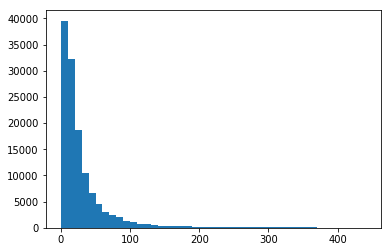

In [12]:
# analyze the comments length in x_train_sequences to decide on a max comment length
comments_lengths = [len(comment) for comment in x_train_sequences]
plt.hist(comments_lengths, bins=np.arange(0, 450, 10))
plt.show()

Looking at the the histogram above reveals that selecting a comment length of 100 should be a safe bet, 
since it covers most of the comments.

In [33]:
max_len = 100

# pad the training, validation, and test sets to have a maximum length of 100
x_train_sequences_padded = pad_sequences(x_train_sequences, maxlen=max_len)
x_validation_sequences_padded = pad_sequences(x_validation_sequences, maxlen=max_len)
x_test_sequences_padded = pad_sequences(x_test_sequences, maxlen=max_len)

### Evaluation Metric

The evaluation metric used in [kaggle](https://www.kaggle.com/c/jigsaw-toxic-comment-classification-challenge#evaluation) is the average of the individual AUROCs of each predicted column. Given that this is a multi-label, multi-class problem with class imbalance, this metric makes sense too. So, we'll use the same metric during model training and evalution.

Note: The AUROC score indicates the probability that a uniformly drawn postive random sample is ranked higher than a uniformly drawn negative random sample. This score is agnostic of the threshold used for classification.

In [14]:
class AUROC(Callback):
    def __init__(self, validation_data=()):
        super(Callback, self).__init__()
        self.x, self.y = validation_data

    def on_epoch_end(self, epoch, logs={}):
        y_pred = self.model.predict(self.x)
        # Calculate roc_auc_score. For multi-label, this function averages over the labels
        score = roc_auc_score(self.y, y_pred)
        print("val AUROC: %.6f" % (score))

### Model 1 (Baseline) - NN Using Count Vectors as Features

In [15]:
def create_count_vector_nn_model():
    model = Sequential()
    # first and only hidden layer with 128 units
    model.add(Dense(128, activation='relu', input_shape=(max_features,)))

    # since we are classifying each label separately, we use a sigmoid function for the output layer and 
    # binary_crossentropy as the loss function
    model.add(Dense(6, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

model_count_vector_nn = create_count_vector_nn_model()

# add early stopping which checks validation loss to avoid overfitting. 
# if the validation loss does not decrease by more than 0.0001 for more than 2 epochs, training stops.
early_stopping = EarlyStopping(monitor='val_loss', min_delta=0.0001, patience=2, verbose=1)

auroc = AUROC(validation_data=(x_validation, y_validation))

hist_count_vector_nn = model_count_vector_nn.fit(x_train, y_train, batch_size=500, epochs=10, 
                                                 validation_data=(x_validation, y_validation), 
                                                 callbacks=[early_stopping, auroc])

# save model in case it's needed later
model_count_vector_nn.save('models/history/count_vector_nn.h5')

# save model history in case it's needed later
with open('models/history/count_vector_nn_hist','wb') as f:
    pkl.dump(hist_count_vector_nn.history, f)

Train on 127656 samples, validate on 31915 samples
Epoch 1/10
127656/127656 [==============================] - 276s 2ms/step - loss: 0.1651 - acc: 0.9681 - val_loss: 0.0878 - val_acc: 0.9759
val AUROC: 0.894829
Epoch 2/10
127656/127656 [==============================] - 232s 2ms/step - loss: 0.0690 - acc: 0.9794 - val_loss: 0.0744 - val_acc: 0.9784
val AUROC: 0.932605
Epoch 3/10
127656/127656 [==============================] - 208s 2ms/step - loss: 0.0530 - acc: 0.9832 - val_loss: 0.0709 - val_acc: 0.9791
val AUROC: 0.943739
Epoch 4/10
127656/127656 [==============================] - 222s 2ms/step - loss: 0.0440 - acc: 0.9857 - val_loss: 0.0701 - val_acc: 0.9796
val AUROC: 0.949563
Epoch 5/10
127656/127656 [==============================] - 201s 2ms/step - loss: 0.0376 - acc: 0.9879 - val_loss: 0.0726 - val_acc: 0.9798
val AUROC: 0.950013
Epoch 6/10
127656/127656 [==============================] - 193s 2ms/step - loss: 0.0328 - acc: 0.9896 - val_loss: 0.0738 - val_acc: 0.9798
val AUROC

Analyzing the validation loss and training loss logged by the model seems to indicate that there is no overfitting.

This model seems to be providing a good result for an intial attempt.

### Model 2 - NN Using Embedding

In [16]:
def create_embedding_nn_model():
    embedding_size = 16
    model_embedding_nn = Sequential()

    # Embedding layer to learn word embeddings. Embedding size chosen is 8
    model_embedding_nn.add(Embedding(max_features, embedding_size, input_length=max_len))

    # Flatten the output of the embedding layer so that it can be given as an input to a hidden layer
    model_embedding_nn.add(Flatten())

    # Single hidden layer with 64 hidden units
    model_embedding_nn.add(Dense(64, activation='relu'))
    model_embedding_nn.add(Dense(6, activation='sigmoid'))
    model_embedding_nn.compile(loss='binary_crossentropy', optimizer='adam')
    
    return model_embedding_nn

model_embedding_nn = create_embedding_nn_model()

early_stopping = EarlyStopping(monitor='val_loss', min_delta=0.0001, patience=2, verbose=1)
auroc = AUROC(validation_data=(x_validation_sequences_padded, y_validation))

# Fit model using early stopping
hist_embedding_nn = model_embedding_nn.fit(x_train_sequences_padded, y_train, batch_size=500, epochs=10, 
                                           validation_data=(x_validation_sequences_padded, y_validation), 
                                           callbacks=[early_stopping, auroc])

model_embedding_nn.save('models/embedding_nn.h5')

with open('models/history/embedding_nn_hist','wb') as f:
    pkl.dump(hist_embedding_nn.history, f)


Train on 127656 samples, validate on 31915 samples
Epoch 1/10
127656/127656 [==============================] - 21s 163us/step - loss: 0.1324 - val_loss: 0.0694
val AUROC: 0.956141
Epoch 2/10
127656/127656 [==============================] - 12s 97us/step - loss: 0.0583 - val_loss: 0.0606
val AUROC: 0.962127
Epoch 3/10
127656/127656 [==============================] - 13s 99us/step - loss: 0.0503 - val_loss: 0.0599
val AUROC: 0.962542
Epoch 4/10
127656/127656 [==============================] - 13s 105us/step - loss: 0.0459 - val_loss: 0.0598
val AUROC: 0.961091
Epoch 5/10
127656/127656 [==============================] - 13s 103us/step - loss: 0.0423 - val_loss: 0.0613
val AUROC: 0.959191
Epoch 00005: early stopping


This model too has a similar performance as that of the baseline model. However, this has a better AUROC and validation loss.

### Model 3 - NN Using a Pre-trained Embedding

The pre-trained model selected is GloVe. The model pre-trained on Twitter data is selected in the hopes that it reflects online user behaviour and generalizes well for our use-case.

In [36]:
# the selected GloVe model is the one with dimension = 100
transfer_embedding_size = 100

# create glove embeddings of our vocabulary
def create_embedding_matrix():
    glove_embeddings_index = dict()
    
    # create the glove embeddings index
    with open('data/glove.twitter.27B.100d.txt', encoding='utf8') as f:
        for line in f:
            values = line.split()
            word = values[0]
            coefs = np.asarray(values[1:], dtype='float32')
            glove_embeddings_index[word] = coefs

    # glove embeddings of our vocabulary
    embedding_matrix = np.zeros((len(tokenizer.word_index)+1, transfer_embedding_size))

    # words in our vocabulary that do not have a corresponding glove embedding
    words_with_no_embedding = []

    for word, i in tokenizer.word_index.items():
        embedding_vector = glove_embeddings_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector
        elif i < 10000:
            words_with_no_embedding.append(word)
        
    print (len(words_with_no_embedding))
    print (words_with_no_embedding)
    
    # save the embedding_matrix for later use
    with open("data/glove_embedding_matrix.pickle", "wb") as f:
        pkl.dump(embedding_matrix, f)
        
    return embedding_matrix
        

def load_embedding_matrix():
    embedding_matrix = None
    with open("data/glove_embedding_matrix.pickle", "rb") as f:
        embedding_matrix = pkl.load(f)
    return embedding_matrix


def create_glove_nn_model():
    model_glove_nn = Sequential()

    # embedding_matrix = create_embedding_matrix()
    embedding_matrix = load_embedding_matrix()
    
    # Embedding layer with weights initialized from glove_embedding_matrix.
    # The weights of the embedding layer will be adjusted during training, since trainable is not set to False.
    # By trial and error, it was found that training the embedding layer yielded better results.
    model_glove_nn.add(Embedding(len(tokenizer.word_index)+1, transfer_embedding_size, input_length=max_len, 
                             weights=[embedding_matrix]))
    # flatten the word embeddings, so that it can be fed to a Dense layer.
    model_glove_nn.add(Flatten())
    model_glove_nn.add(Dense(256, activation='relu'))
    model_glove_nn.add(Dense(6, activation='sigmoid'))

    model_glove_nn.compile(loss='binary_crossentropy', optimizer='adam')
    return model_glove_nn


model_glove_nn = create_glove_nn_model()
early_stopping = EarlyStopping(monitor='val_loss', min_delta=0.0001, patience=2, verbose=1)
auroc = AUROC(validation_data=(x_validation_sequences_padded, y_validation))

hist_glove_nn = model_glove_nn.fit(x_train_sequences_padded, y_train, batch_size=500, epochs=10,
                                  validation_data=(x_validation_sequences_padded, y_validation),
                                  callbacks=[early_stopping, auroc])

model_glove_nn.save('models/glove_nn.h5')
with open('models/history/glove_nn_hist', 'wb') as f:
    pkl.dump(hist_glove_nn.history, f)

400
["don't", "i'm", "it's", "i've", "you're", "doesn't", "that's", "i'll", "didn't", "can't", "isn't", "i'd", "there's", 'contribs', "wikipedia's", "you've", "wasn't", "won't", "he's", 'wikiproject', 'npov', "haven't", "article's", "what's", "wouldn't", "aren't", "shouldn't", "let's", "they're", "you'll", 'infobox', "we're", "''''''", "you'd", 'barnstar', 'unsourced', 'wikipedians', "couldn't", 'fucksex', 'sockpuppet', 'disambiguation', 'fffa', "here's", 'buttsecks', "subject's", 'arbcom', 'verifiability', 'userpage', "people's", 'philippineslong', '—preceding', 'mothjer', "hasn't", 'talkpage', 'offfuck', 'gfdl', 'oldid', 'sexsex', 'deneid', "we'll", "'fuck", 'pagedelete', 'yourselfgo', 'notrhbysouthbanof', "'image'", "weren't", "'''", "we've", 'sockpuppetry', 'cellpadding', "she's", 'bunksteve', 'marcolfuck', 'unconstructive', 'ytmnd', 'deletions', "who's", 'securityfuck', "user's", 'mainpagebg', 'adminship', 'youbollocks', "hadn't", "they've", 'don’t', "''''", '\u200e', 'conformance

There are 400 words in our vocabulary that do not have a corresponding embedding in glove. Most of them seems to be ones that can be safely ignored. 

The performance of this model is better than that of the model with a learned embedding. However, an embedding layer initialized with glove vectors but not trainable had yielded worse results. (Those results are not shown in this notebook). 

### Model 4 - RNN Using Embedding

Since the glove model yielded better results, trying an RNN with LSTM cell that uses the same trainable embedding. Keeping track of the words in the comments in memory might prove to be useful to understand the comment better. This is the intuition behind using an RNN. Also, since words early on in the comment could be more useful, we are using an LSTM.

In [62]:
def create_rnn_model():
    embedding_size = 16
    model_embedding_rn = Sequential()
    
    # load GloVe embedding matrix used in previous model
    embedding_matrix = load_embedding_matrix()
    
    # trainable embedding layer initialized using the embedding matrix from above
    model_embedding_rn.add(Embedding(len(tokenizer.word_index)+1, transfer_embedding_size, input_length=max_len, 
                             weights=[embedding_matrix]))

    # LSTM layer with dropout - since LSTMs are prone to overfitting
    model_embedding_rn.add(LSTM(100, dropout=0.1, recurrent_dropout=0.1))
    model_embedding_rn.add(Dense(32, activation='relu'))
    # more dropout regularization
    model_embedding_rn.add(Dropout(0.1))
    model_embedding_rn.add(Dense(6, activation='sigmoid'))
    model_embedding_rn.compile(loss='binary_crossentropy', optimizer='adam')
    
    return model_embedding_rn


model_embedding_rn = create_rnn_model()

early_stopping = EarlyStopping(monitor='val_loss', min_delta=0.0001, patience=2, verbose=1)
auroc = AUROC(validation_data=(x_validation_sequences_padded, y_validation))

hist_embedding_rn = model_embedding_rn.fit(x_train_sequences_padded, y_train, batch_size=500, epochs=20, 
                                           validation_data=(x_validation_sequences_padded, y_validation), 
                                           callbacks=[early_stopping, auroc])

model_embedding_rn.save('models/embedding_rn.h5')

with open('models/history/embedding_rn_hist','wb') as f:
    pkl.dump(hist_embedding_rn.history, f)

Train on 114890 samples, validate on 12766 samples
Epoch 1/20
114890/114890 [==============================] - 1055s 9ms/step - loss: 0.1318 - val_loss: 0.0546
val AUROC: 0.970560
Epoch 2/20
114890/114890 [==============================] - 1117s 10ms/step - loss: 0.0552 - val_loss: 0.0494
val AUROC: 0.974625
Epoch 3/20
114890/114890 [==============================] - 1160s 10ms/step - loss: 0.0489 - val_loss: 0.0480
val AUROC: 0.977281
Epoch 4/20
114890/114890 [==============================] - 1231s 11ms/step - loss: 0.0453 - val_loss: 0.0477
val AUROC: 0.978690
Epoch 5/20
114890/114890 [==============================] - 1325s 12ms/step - loss: 0.0426 - val_loss: 0.0477
val AUROC: 0.979430
Epoch 6/20
114890/114890 [==============================] - 1282s 11ms/step - loss: 0.0401 - val_loss: 0.0496
val AUROC: 0.979345
Epoch 00006: early stopping


Based on the validation loss and the validation auroc score, this seems to be the better model. However, the training time for the model to converge is higher compared to the other models.

In [80]:
# Load the best-performing model
from keras.models import load_model
def load_saved_rnn_model():
    return load_model('models/embedding_rn.h5')

### Prediction on Test Data using the Selected Model

Since the RNN has the best performance in terms of validation loss and validation auroc score, we select that.

In [81]:
model = load_saved_rnn_model()

# predict on held-out test data
y_pred = model.predict(x_test_sequences_padded)

### Test Result Analysis
Analyze AUROC scores and confusion matrix to get a better idea of the results, since there is class imbalance

In [82]:
# analyze mean auroc score and auroc score for each label
auroc_score = roc_auc_score(y_test, y_pred)
print ('Mean AUROC Score:', auroc_score)

for i in range(0, 6):
    print (dependent_vars[i], ':', roc_auc_score(y_test[:, i], y_pred[:, i]))

Mean AUROC Score: 0.9800690380177524
toxic : 0.9734392480335463
severe_toxic : 0.9878210443845843
obscene : 0.9886028243622969
threat : 0.9727391591260901
insult : 0.9806614957212978
identity_hate : 0.977150456478699


The mean AUROC score of the validation data has translated well to the test data. The model seems to predicting 'obscene' labels well. On the other hand, 'threat' and 'identity_hate' labels seem to have taken a hit. This could be due to the label imbalance.

In [83]:
# make absolute predictions using a threshold of 0.5
threshold = 0.5
y_pred[y_pred >= threshold] = 1
y_pred[y_pred < threshold] = 0

In [88]:
# check confusion matrix for each label
for i in range(0, 6):
    print (dependent_vars[i])
    print ('TN,      FP,    FN,    TP')
    print (confusion_matrix(y_test[:, i], y_pred[:, i]).ravel())
    print ('\n')

toxic
TN,      FP,    FN,    TP
[28526   272   944  2173]


severe_toxic
TN,      FP,    FN,    TP
[31495    60   285    75]


obscene
TN,      FP,    FN,    TP
[29956   252   340  1367]


threat
TN,      FP,    FN,    TP
[31819     4    89     3]


insult
TN,      FP,    FN,    TP
[29975   333   534  1073]


identity_hate
TN,      FP,    FN,    TP
[31612    34   204    65]




The analysis above seems to be right. The model especially seems to be struggling with the threat label. It is reluctant to label a comment as a threat - only 3 TPs out of ~32K data points when in fact there were 92 true labels.

### Analyze Misclassified Threat Comments

In [ ]:
pd.set_option('display.max_colwidth', -1)
print ("Comments that are TP threats: ")
print (test['comment_text'].loc[np.logical_and(y_pred[:, 3] == 1, y_test[:, 3] == 1)])

print ("\n\n\nComments that are FN threats: ")
print (test['comment_text'].loc[np.logical_and(y_pred[:, 3] == 0, y_test[:, 3] == 1)])

As seen from the examples above, the model seems to need strong evidence without too much dilution of features like 'kill' and 'die' by other words, to label a comment as a threat.

### Improvements

##### Code Improvements:
1. Use scikit-learn Pipeline to modularize the code more.
2. Use GridSearchCV for better tuning of hyperparameters

##### Model Improvements:
1. Set the 'class_weights' parameter in the fit function to inverse class frequencies as mentioned [here](https://keras.io/models/sequential/#fit).
2. Try an ensemble of models with each model focusing on one label. Each model can then try to optimize an f1_score for the label it focuses on.
3. Pseudo-labeling could be tried after the model reaches a satisfactory performance on labels that are causing issues.
4. Use more efficient preprocessing:
   a) Remove spelling mistakes by using edit distances. A GloVe or similar model could be used to correct these mistakes.
   b) Try a bigger vocabulary size
   c) Lemmatizing
5. Choose better thresholds for the different labels for prediction.